In [144]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import *

import seaborn as sns

from PIL import Image, ImageDraw

In [145]:
# unit definitions
METER = 64/(40075*10**3)
SECOND = 1.0/86400.0
JOULE = METER**2/SECOND**2
KELVIN = JOULE
NEWTON = METER/SECOND**2
WATT = METER**2/SECOND**3

In [146]:
# constants
N = 32
STEPS = 2400
T0 = 0.0
DT = 0.01

NU = 18.03 / (NEWTON*SECOND/METER**2)
RHO = 18
RHO_AQ = 1025 #/ (1 / METER**3)
SIGMA = 1.380649*10**(-23) #/ (WATT/(METER**2 * KELVIN**4))
S0 = 1361 #/ (WATT/METER**2)
ALBEDO = 0.3
EMISSIVITY = 1.0
C_SP = 3990
MIXED_LAYER_DEPTH = 70 #/ METER

DAY_LENGTH = 24.0
YEAR_LENGTH = 365.25

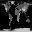

In [147]:
img = Image.open("heightmap.png")
img = img.resize((N, N), Image.Resampling.NEAREST)
height_data = np.asarray(img.getchannel('R'))
#height_data = np.array([np.delete(i, np.arange(0,512,2)) for i in height_data])
Image.fromarray(height_data)

In [165]:
import perlin_noise

# fourier space variables
kx, ky = np.meshgrid(
    np.arange(-N/2, N/2, dtype=np.float64),
    np.arange(-N/2, N/2, dtype=np.float64))

kx = ifftshift(kx)
ky = ifftshift(ky)
kSq = kx**2 + ky**2

kmax = np.max(kx)
mask = np.astype((np.abs(kx) < (2.0 / 3.0) * kmax) & (np.abs(ky) < (2.0 / 3.0) * kmax), np.int64)

invKSq = 1.0 / kSq
invKSq[kSq == 0] = 0.0

kx *= mask
ky *= mask
kSq *= mask
invKSq *= mask

# helper functions
def advec(_u, _v, _kx, _ky, A):
    Ax = np.real(ifft2(1j*kx*A))
    Ay = np.real(ifft2(1j*ky*A))

    return fft2(_u*Ax + _v*Ay) * mask

def pressure(_kx, _ky, _invKSq, _omega):
    ux = np.real(ifft2(-_kx**2*_invKSq*_omega))
    uy = np.real(ifft2(-_kx*_ky*_invKSq*_omega))
    vx = np.real(ifft2(-_kx*_ky*_invKSq*_omega))
    vy = np.real(ifft2(-_kx**2 *_invKSq*_omega))

    return np.real(ifft2(_invKSq * fft2(ux**2 + vy**2 + 2*uy*vx)))

def coriolis(_u):
    return fft2(4*np.pi/DAY_LENGTH * np.sin(lattitude) * _u) * mask

def dTdt(T, t, t0):
    T_real = np.real(ifft2(T)) * (KELVIN * METER**2 / SECOND)
    C = RHO_AQ * C_SP * MIXED_LAYER_DEPTH

    utc_day = (t0 + t) % YEAR_LENGTH

    dec = np.deg2rad(-23.44*np.cos(np.deg2rad((YEAR_LENGTH - 5)/YEAR_LENGTH*(utc_day + 10))))
    local_day = (utc_day + 90/15 * longitude) % DAY_LENGTH

    utc_time = (utc_day % 1)
    hour_angle = 2*np.pi*((utc_time + 0.5*longitude) % 1 - 0.5)

    theta = (
        np.sin(0.5*np.pi*lattitude) * np.sin(dec) + 
        np.cos(0.5*np.pi*lattitude) * np.cos(dec) * np.cos(hour_angle)
    )
    theta = np.maximum(theta, 0)

    absorbed = (1 - ALBEDO) * S0*theta
    olr = EMISSIVITY * SIGMA * T_real**4
    net_radiation = absorbed - olr
    
    return fft2((net_radiation / C) / (KELVIN * METER**2 / SECOND)) * mask

def omega_0(_x: np.array, _y: np.array) -> np.array:
    return perlin_noise.generate_perlin_noise_2d((N,N), (int(N/2),int(N/2)), (True,True))

def T_0() -> np.array:
    return 300 + 0.05*np.real(ifft2(dTdt(np.zeros((N,N), dtype=np.complex256), T0, T0)))

/tmp/ipykernel_1075954/2627328784.py:15: RuntimeWarning: divide by zero encountered in divide
  invKSq = 1.0 / kSq


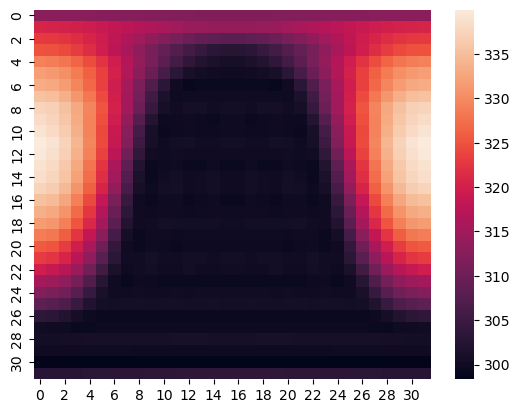

In [166]:
x, y = np.meshgrid(np.linspace(0, 2*np.pi, N), np.linspace(0, 2*np.pi, N), indexing='ij')
(longitude, lattitude) = np.meshgrid(np.linspace(-1,1,N), np.linspace(-1,1,N))

omega = np.zeros((N, N, STEPS+1), dtype=np.complex256)
omega[:,:,0] = omega_0(x,y)
omega[:,:,0] = fft2(omega[:,:,0])

T = np.zeros((N, N, STEPS+1), dtype=np.complex256)
T[:,:,0] = T_0() / (KELVIN * METER**2 / SECOND)
T[:,:,0] = fft2(T[:,:,0])

u = np.zeros((N, N, STEPS), dtype=np.float64)
v = np.zeros((N, N, STEPS), dtype=np.float64)
p = np.zeros((N, N, STEPS), dtype=np.float64)

omega[:,:,0] *= mask
T[:,:,0] *= mask

sns.heatmap(np.real(ifft2(T[:,:,0])) * (KELVIN * METER**2 / SECOND))
plt.show()

In [167]:
# crank nicholson (viscous flow)

C = np.zeros_like(u, dtype=np.complex256)

for i in range(STEPS):
    u[:,:,i] = np.real(ifft2(1j*ky*invKSq*omega[:,:,i]))
    v[:,:,i] = np.real(ifft2(-1j*kx*invKSq*omega[:,:,i]))
    p[:,:,i] = pressure(kx, ky, invKSq, omega[:,:,i])

    T_advec_term = advec(u[:,:,i], v[:,:,i], kx, ky, T[:,:,i])
    T[:,:,i+1] = T[:,:,i] + DT * (dTdt(T[:,:,i], T0+DT, T0) + T_advec_term)

    advec_term = advec(u[:,:,i], v[:,:,i], kx, ky, omega[:,:,i])
    coriolis_term = coriolis(u[:,:,i])
    omega[:,:,i+1] = 1./(1./DT + 0.5*NU*kSq)*((1./DT - 0.5*NU*kSq) * omega[:,:,i] - advec_term - coriolis_term)

p[:,:,STEPS-1]

array([[-0.00536893, -0.00984314, -0.01364789, ...,  0.00614176,
         0.00295046, -0.00110506],
       [-0.0049134 , -0.00913579, -0.01311298, ...,  0.00465915,
         0.00184688, -0.00137103],
       [-0.00506435, -0.00838992, -0.01209937, ...,  0.00287673,
         0.00036769, -0.00225634],
       ...,
       [-0.00705717, -0.01084462, -0.014101  , ...,  0.00485317,
         0.00110011, -0.0029424 ],
       [-0.00678026, -0.01082457, -0.01415205, ...,  0.00644654,
         0.00258789, -0.00213027],
       [-0.00615819, -0.01045233, -0.01397963, ...,  0.00689837,
         0.00329343, -0.00144176]], shape=(32, 32))

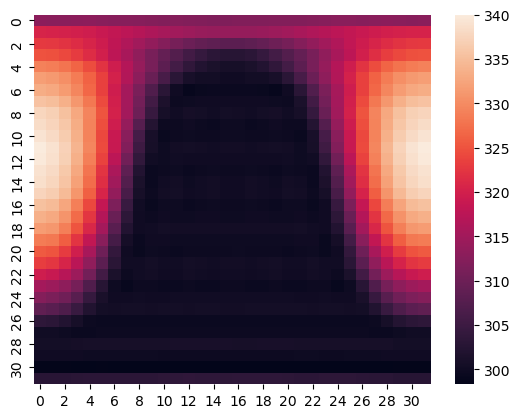

In [168]:
res = np.real(ifft2(T[:,:,6])) #np.real(ifft2(-kx**2*invKSq*omega[:,:,0])) + np.real(ifft2(-kx**2 *invKSq*omega[:,:,0]))

sns.heatmap(res * (KELVIN * METER**2 / SECOND))
plt.show()

In [169]:
def plot_data(i):
    data = np.array(np.real(ifft2(T[:,:,i])) * (KELVIN * METER**2 / SECOND), dtype=np.float64) #np.array(np.real(ifft2(dTdt(T[:,:,i], T0+DT*i, T0))), dtype=np.float64)
    return (data - np.min(data))/(np.max(data) - np.min(data))

VIS_SCALE = 4

#Image.fromarray(255*plot_data(0)).show().resize((2*N, N), Image.Resampling.LANCZOS)
images = []

for i in range(STEPS):
    im = Image.fromarray(255*plot_data(i)).resize((2*VIS_SCALE*N, VIS_SCALE*N), Image.Resampling.LANCZOS)
    images.append(im)

images[0].save('temp_anim.gif', save_all=True, append_images = images[1:], optimize=False, duration=40)

In [153]:
# from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots(figsize=(10,10))
# heatmap = sns.heatmap(plot_data(0), square=True, vmax=1.0, cbar=False)

# def init():
#     ax.clear()
#     sns.heatmap(plot_data(0), square=True, vmax=1, cbar=False)

# def animate(i):
#     ax.clear()
#     sns.heatmap(plot_data(i), square=True, vmax=1, cbar=False)
#     return ax

# anim = FuncAnimation(fig, animate, init_func=init, frames=50)
# anim.save("temp_anim.gif")